# **VGG16 - FINE TUNING para clasificación de imágenes de satélites**

##**Preparación de los datos de entrenamiento y de validación**

Acceso al Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Comprobar si se emplea una GPU.

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Librerías necesarias de Python.

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16

Separación del conjunto de datos en entrenamiento y validación.

In [5]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab/datasets/WorldStrat",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab/datasets/WorldStrat",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 3740 files belonging to 10 classes.
Using 2992 files for training.
Found 3740 files belonging to 10 classes.
Using 748 files for validation.


##**Preparación del modelo**

Utilización de capas preentrenadas para el Fine-Tuning.

In [6]:
# FINE TUNING MODEL
# Include_top is set to False, to exclude the model's fully connected layers
base_model = keras.applications.VGG16(
    weights='imagenet',                 # Load weights pre-trained on ImageNet
    input_shape=(256, 256, 3),
    include_top=False) 

# Trainable layers in VGG16
# Leaving the last two layers unfrozen for Fine-Tuning
for layer in base_model.layers[:17]:
    layer.trainable = False

# Creation of a new top of the model (Fully-connected layers)
inputs = keras.Input(shape=(256, 256, 3))
x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
  # Convert features of shape 'base_model.output_shape[1:]' to vectors
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

# Group convolutional base and new fully-connected layers
model = keras.Model(inputs, outputs)

58889256/58889256 [==============================] - 2s 0us/step


Comprobación del número de capas entrenables del modelo VGG16.

In [7]:
for  i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True


##**Entrenamiento**

Compilación del modelo para el entrenamiento.

In [8]:
# Fine-Tuning model with a lower learning rate, help to learn robust patterns
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
94/94 [==============================] - 579s 6s/step - loss: 1.4826 - accuracy: 0.8463 - val_loss: 0.2231 - val_accuracy: 0.9532
Epoch 2/200
94/94 [==============================] - 23s 241ms/step - loss: 0.1162 - accuracy: 0.9746 - val_loss: 0.0551 - val_accuracy: 0.9866
Epoch 3/200
94/94 [==============================] - 23s 244ms/step - loss: 0.0256 - accuracy: 0.9936 - val_loss: 0.0624 - val_accuracy: 0.9840
Epoch 4/200
94/94 [==============================] - 23s 243ms/step - loss: 0.0707 - accuracy: 0.9863 - val_loss: 0.0748 - val_accuracy: 0.9786
Epoch 5/200
94/94 [==============================] - 24s 246ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.0283 - val_accuracy: 0.9933
Epoch 6/200
94/94 [==============================] - 23s 245ms/step - loss: 0.0275 - accuracy: 0.9926 - val_loss: 0.0711 - val_accuracy: 0.9840
Epoch 7/200
94/94 [==============================] - 24s 246ms/step - loss: 0.0802 - accuracy: 0.9820 - val_loss: 0.2323 - val_accuracy: 0

Guardar el modelo obtenido.

In [9]:
model.save('vgg16_model.h5')

##**Evaluación del modelo obtenido**

Visualización de la precisión y pérdidas del conjunto de entrenamiento y validación mediante matplotlib.

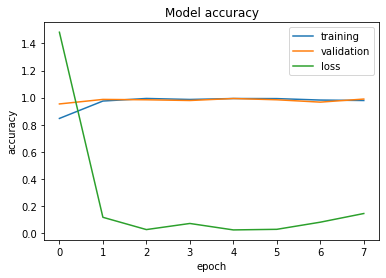

In [10]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation','loss'], loc='upper right')
plt.show()

Matriz de confusión.

1/1 [==============================] - 0s 124ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        63
           1     1.0000    1.0000    1.0000        80
           2     1.0000    0.9882    0.9941        85
           3     1.0000    1.0000    1.0000        79
           4     0.9885    0.9885    0.9885        87
           5     1.0000    1.0000    1.0000        73
           6     0.9592    1.0000    0.9792        47
           7     0.9868    0.9868    0.9868        76
           8     1.0000    1.0000    1.0000        76
           9     0.9877    0.9756    0.9816        82

    accuracy                         0.9933       748
   macro avg     0.9922    0.9939    0.9930       748
weighted avg     0.9934    0.9933    0.9933       748



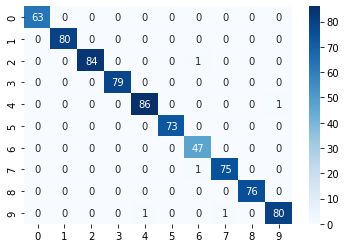

In [11]:
# Evaluación de resultados
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

##**Predicción con conjunto de test**

Prueba de predicción de la clase de la imagen dada, perteneciente al conjunto de datos de test.

(256, 256, 3)
1/1 [==============================] - 1s 582ms/step
The predicted output is : Coastline


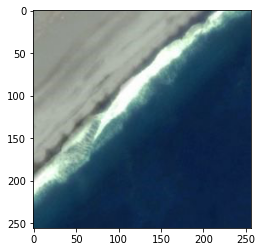

In [12]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import keras

model = keras.models.load_model("vgg16_model.h5")

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab/datasets/Test/coastline(412).jpg', 'r')
im = np.asarray(pil_im.resize((256, 256)))
imshow(im)
print(im.shape) # Image array dimension: 256x256x3

im = im.reshape(1,256,256,3)
prediction = model.predict(im)

result = np.argmax(prediction)

c = {0 : 'Airplanes', 1: 'BareLand', 2: 'CityBuilding', 3: 'Coastline', 4: 'Farmland', 5 : 'Forest', 6 : 'Highway', 7 : 'Marina', 
         8: 'Residents', 9: 'Rivers'}

print("The predicted output is :",c[result])